In [8]:
import os
import argparse
import numpy as np
import os.path as osp
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.utils as vutils
from torch.utils.data import DataLoader

from src.datasets import DatasetBuilder
from src.models.classifiers import SimpleCNNtorch
from src.models.vae import BetaVAE
from src.cf_methods import Revise
from src.evaluation.local_instability import perturb_sample
from src.utils import extract_factual_instances, filter_valid_factuals
from src.utils import seed_everything, get_config, load_model_weights
from src.utils import evaluate_classification_model, plot_boxplot
from src.cf_methods.c3lt import models 

In [9]:
seed_everything()

plt.style.use('seaborn-v0_8-darkgrid')
params = {"text.color" : "black"}
plt.rcParams.update(params)

## Load data

In [12]:
config_path = r'/data/leuven/365/vsc36567/CF-Robustness-Benchmark/configs/train_classifier_fmnist.yaml'
# r"D:\PycharmProjects\CF-Robustness-Benchmark\configs\revise_mnist_binary.yaml"
config = get_config(config_path)

BATCH_SIZE = config.batch_size
img_size = config.data.img_size

In [16]:
ds_builder = DatasetBuilder(config)
ds_builder.setup()
train_loader, val_loader, test_loader = ds_builder.get_dataloaders()

In [13]:
config.data.classes

[0, 4]

In [9]:
# preprocessing
# download = True


# data_dir = r'D:\PycharmProjects\Counterfactual-Robustness-Benchmark\data'
# r"/vsc-hard-mounts/leuven-data/365/vsc36567/Counterfactual-Robustness-Benchmark/data"
# data_flag = "FashionMNIST"
# ds_names = ['train', 'val','test']
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# classes = ['all'] #[1, 8]

# datasets = {}
# for ds_name in ds_names:
#     datasets[ds_name] = FashionMNISTDataset(data_flag, 
#                                     split=ds_name, 
#                                     data_dir=data_dir, 
#                                     size=img_size, 
#                                     download=download,
#                                     increase_channels=False,
#                                     undersample=False,
#                                     channels_first=True,
#                                     classes=classes)

# # unique_targets = np.unique(datasets['train'].data.targets).tolist()
# NUM_CLASSES = len(datasets['train'].data.classes)

# print(f"{data_flag.capitalize()} dataset has been successfully loaded")
# print("Unique classes: ", datasets['train'].data.classes)

Fashionmnist dataset has been successfully loaded
Unique classes:  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [10]:
# train_loader = DataLoader(dataset=datasets['train'], batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(dataset=datasets['val'], batch_size=BATCH_SIZE, shuffle=True) 
# test_loader = DataLoader(dataset=datasets['test'], batch_size=BATCH_SIZE, shuffle=True) 

In [14]:
z = 100
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
nc = 1 # Number of channels
beta1 = 0.5 # Beta1 hyperparameter for Adam optimizers
lr = 0.0002 # Learning rate for optimizers
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

## Build DCGAN object  

In [12]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
gen = models.Generator(latent_dim=z, ngf=ngf, nc=nc).to(device)
discr = models.Discriminator(ndf=ndf, nc=1).to(device)

gen.apply(weights_init);
discr.apply(weights_init);

In [14]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(BATCH_SIZE, z, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerG = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = torch.optim.Adam(discr.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 15

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discr.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discr(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, z, 1, 1, device=device)
        # Generate fake image batch with G
        fake = gen(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discr(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        gen.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discr(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(test_loader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

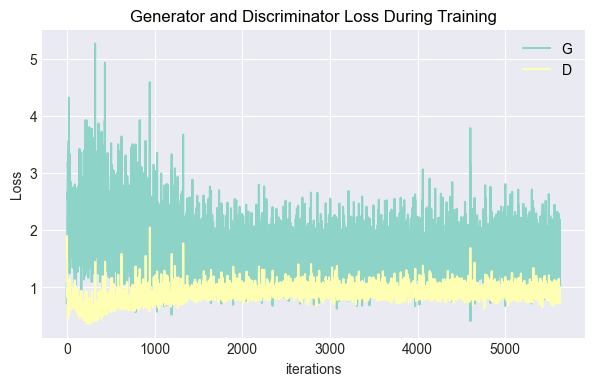

In [16]:
plt.figure(figsize=(7,4))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

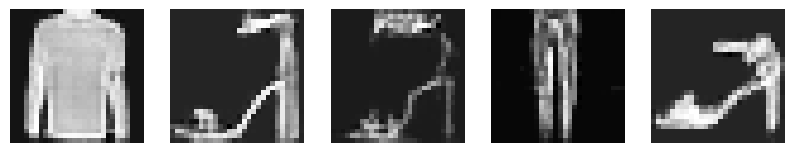

In [17]:
n_samples = 5
fig, axs = plt.subplots(1, n_samples, figsize=(10, 4))

noise_vector = torch.randn(BATCH_SIZE, z, 1, 1, device=device)
gen_images = gen(noise_vector).detach().cpu()

for j in range(n_samples):
    axs[j].imshow(gen_images[j].squeeze(0), cmap='gray')
    axs[j].axis("off")


In [19]:
save_dir = r'/data/leuven/365/vsc36567/CF-Robustness-Benchmark/src/cf_methods/c3lt/weights'
# r'D:\PycharmProjects\Counterfactual-Robustness-Benchmark\src\recourse_methods\c3lt\weights'
# r'/data/leuven/365/vsc36567/Counterfactual-Robustness-Benchmark/src/recourse_methods/c3lt/weights'

torch.save(gen.state_dict(), osp.join(save_dir, 'generator_fmnist.pth'))
torch.save(discr.state_dict(), osp.join(save_dir, 'discriminator_fmnist.pth'))

## Train AE

In [17]:
ae = models.ConvolutionalAuntoencoder(latent_dim=z, nc=nc, ndf=32, ngpu=1).to(device)

In [18]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 30

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    

    for data in tqdm(train_loader):
        images, _ = data
        images = images.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        outputs = ae(images)
        loss = criterion(outputs, images)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))


100%|██████████| 150/150 [00:01<00:00, 93.38it/s] 


Epoch: 1 	Training Loss: 31.008222


100%|██████████| 150/150 [00:00<00:00, 179.27it/s]


Epoch: 2 	Training Loss: 16.078472


100%|██████████| 150/150 [00:00<00:00, 179.13it/s]


Epoch: 3 	Training Loss: 8.622158


100%|██████████| 150/150 [00:00<00:00, 179.63it/s]


Epoch: 4 	Training Loss: 4.519194


100%|██████████| 150/150 [00:00<00:00, 178.81it/s]


Epoch: 5 	Training Loss: 2.350265


100%|██████████| 150/150 [00:00<00:00, 177.15it/s]


Epoch: 6 	Training Loss: 1.276766


100%|██████████| 150/150 [00:00<00:00, 177.54it/s]


Epoch: 7 	Training Loss: 0.766945


100%|██████████| 150/150 [00:00<00:00, 179.47it/s]


Epoch: 8 	Training Loss: 0.549339


100%|██████████| 150/150 [00:00<00:00, 180.32it/s]


Epoch: 9 	Training Loss: 0.462289


100%|██████████| 150/150 [00:00<00:00, 179.66it/s]


Epoch: 10 	Training Loss: 0.434693


100%|██████████| 150/150 [00:00<00:00, 180.20it/s]


Epoch: 11 	Training Loss: 0.413127


100%|██████████| 150/150 [00:00<00:00, 179.92it/s]


Epoch: 12 	Training Loss: 0.396175


100%|██████████| 150/150 [00:00<00:00, 179.47it/s]


Epoch: 13 	Training Loss: 0.388250


100%|██████████| 150/150 [00:00<00:00, 180.25it/s]


Epoch: 14 	Training Loss: 0.375806


100%|██████████| 150/150 [00:00<00:00, 179.52it/s]


Epoch: 15 	Training Loss: 0.369058


100%|██████████| 150/150 [00:00<00:00, 178.85it/s]


Epoch: 16 	Training Loss: 0.355589


100%|██████████| 150/150 [00:00<00:00, 176.99it/s]


Epoch: 17 	Training Loss: 0.354010


100%|██████████| 150/150 [00:00<00:00, 179.68it/s]


Epoch: 18 	Training Loss: 0.349638


100%|██████████| 150/150 [00:00<00:00, 178.98it/s]


Epoch: 19 	Training Loss: 0.337686


100%|██████████| 150/150 [00:00<00:00, 180.05it/s]


Epoch: 20 	Training Loss: 0.336016


100%|██████████| 150/150 [00:00<00:00, 180.65it/s]


Epoch: 21 	Training Loss: 0.328000


100%|██████████| 150/150 [00:00<00:00, 179.38it/s]


Epoch: 22 	Training Loss: 0.327492


100%|██████████| 150/150 [00:00<00:00, 179.14it/s]


Epoch: 23 	Training Loss: 0.320350


100%|██████████| 150/150 [00:00<00:00, 180.07it/s]


Epoch: 24 	Training Loss: 0.317512


100%|██████████| 150/150 [00:00<00:00, 180.31it/s]


Epoch: 25 	Training Loss: 0.312747


100%|██████████| 150/150 [00:00<00:00, 179.97it/s]


Epoch: 26 	Training Loss: 0.312799


100%|██████████| 150/150 [00:00<00:00, 179.65it/s]


Epoch: 27 	Training Loss: 0.308320


100%|██████████| 150/150 [00:00<00:00, 179.41it/s]


Epoch: 28 	Training Loss: 0.307529


100%|██████████| 150/150 [00:00<00:00, 177.97it/s]


Epoch: 29 	Training Loss: 0.301431


100%|██████████| 150/150 [00:00<00:00, 177.53it/s]

Epoch: 30 	Training Loss: 0.298344


Recon loass: 0.00357


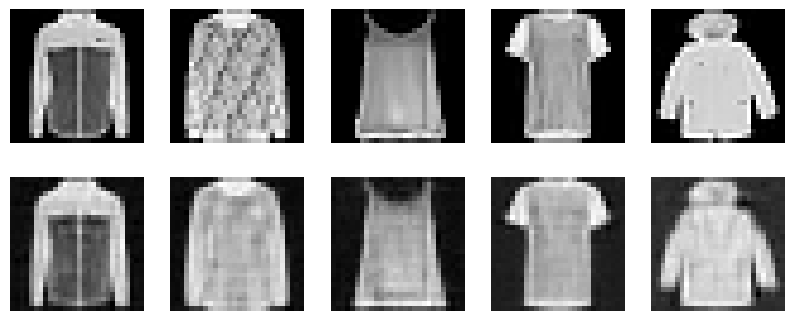

In [19]:
n_samples = 5
fig, axs = plt.subplots(2, n_samples, figsize=(10, 4))

images, _ = next(iter(train_loader))
recon = ae(images.to(device)).detach().cpu()
recon_loss = criterion(images, recon).item()

for j in range(n_samples):
    axs[0, j].imshow(images[j].squeeze(0), cmap='gray')
    axs[0, j].axis("off")
    axs[1, j].imshow(recon[j].squeeze(0), cmap='gray')
    axs[1, j].axis("off")

print(f'Recon loass: {recon_loss:.5f}')


In [21]:
save_dir = '/data/leuven/365/vsc36567/CF-Robustness-Benchmark/src/cf_methods/c3lt/weights'
# r'D:\PycharmProjects\Counterfactual-Robustness-Benchmark\src\recourse_methods\c3lt\weights'

torch.save(ae.state_dict(), osp.join(save_dir, 'ae_fmnist.pth'))

In [22]:
torch.save(ae.encoder.state_dict(), osp.join(save_dir, 'encoder_fmnist.pth'))